# Network Characterization

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install powerlaw
!pip install node_conformity
clear_output()

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import powerlaw
import math
import random

from statistics import mean, stdev
from sklearn.preprocessing import KBinsDiscretizer

from operator import itemgetter

In [ ]:
#net_char function is used to extract interesting information from a graph networkx object
#and save it in a compact way inside a dictionary

def net_char(G):
  return {'node_num' : G.number_of_nodes(),
   'edges_num' : G.number_of_edges(),
   'directed' : G.is_directed(),
   'max_edges_num' : ((G.number_of_nodes()) * (G.number_of_nodes() - 1)) / 2,         #N(N-1)/2
   'self_loops_num' : nx.number_of_selfloops(G),
   'average_degree' : (2 *  G.number_of_edges())/G.number_of_nodes(),                 #2L/N
   'highest_degree' : max([x[1] for x in list(G.degree())]),
   'lowest_degree' : min([x[1] for x in list(G.degree())]),
   'num_connected_components' : len(list(nx.connected_components(G))),
   'size_biggest_component' : len(sorted(list(nx.connected_components(G)), key=len, reverse = True)[0]),
   'density' : nx.density(G),
   'triangles_number' : sum(nx.triangles(G).values()),
   'avg_clustering_coefficient' : nx.average_clustering(G),
   'assortativity' : nx.degree_assortativity_coefficient(G)
  }


#hub net is used to extract nodes with a degree >= then a threshold

def hub_net(G, threshold):
  hubs = [node for node in list(G.nodes()) if G.degree(node) >= threshold ]
  not_hubs = [node for node in list(G.nodes()) if G.degree(node) < threshold ]
  return hubs, not_hubs


def plot_dist(G):
    M = to_scipy_sparse_matrix(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).A[0]
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)


    fig = plt.figure(figsize=(16, 6))
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()


def show_barplot(l, n = 10):
    '''l = list'''
    label = list(zip(*l))[0]
    label_top = label[:n]
    score = list(zip(*l))[1]
    score_top = score[:n]
    plt.figure(figsize=(16,7))
    x_pos = np.arange(len(label_top))
    plt.bar(x_pos, score_top, color = "#BCE4D7")
    plt.xlabel("Twitter users")
    plt.xticks(x_pos, label_top, rotation = 15, fontsize=10)
    plt.ylabel('Popularity Score', fontsize = 10)
    plt.show()


In [ ]:
#compoute an approximation of the shortest path length

def approximate_shortest_path_length(graph, num_internal_samples = 200, num_external_samples = 100, seed = 42):
  nodes = list(graph.nodes())
  external_samples = []
  for k in range(num_external_samples):
    lenghts = []

    for _ in range(num_internal_samples):
      random.seed(seed)
      n1, n2 = random.choices(nodes, k = 2)
      length = nx.shortest_path_length(graph, source=n1, target=n2)
      lenghts.append(length)
      seed += 1 #we update the seed to choose a different pair of nodes

    external_samples.append(mean(lenghts))


  return mean(external_samples), stdev(external_samples)

In [ ]:
with open("artists_graph_20.pickle", 'rb') as f:
    G = pickle.load(f)

### Sparse Matrix Implementation from networkx 1.10

In [ ]:
def edges_iter(self, nbunch=None, data=False, default=None):
        """Return an iterator over the edges.

        Edges are returned as tuples with optional data
        in the order (node, neighbor, data).

        Parameters
        ----------
        nbunch : iterable container, optional (default= all nodes)
            A container of nodes.  The container will be iterated
            through once.
        data : string or bool, optional (default=False)
            The edge attribute returned in 3-tuple (u,v,ddict[data]).
            If True, return edge attribute dict in 3-tuple (u,v,ddict).
            If False, return 2-tuple (u,v).
        default : value, optional (default=None)
            Value used for edges that dont have the requested attribute.
            Only relevant if data is not True or False.

        Returns
        -------
        edge_iter : iterator
            An iterator of (u,v) or (u,v,d) tuples of edges.

        See Also
        --------
        edges : return a list of edges

        Notes
        -----
        Nodes in nbunch that are not in the graph will be (quietly) ignored.
        For directed graphs this returns the out-edges.

        Examples
        --------
        >>> G = nx.Graph()   # or MultiGraph, etc
        >>> G.add_path([0,1,2])
        >>> G.add_edge(2,3,weight=5)
        >>> [e for e in G.edges_iter()]
        [(0, 1), (1, 2), (2, 3)]
        >>> list(G.edges_iter(data=True)) # default data is {} (empty dict)
        [(0, 1, {}), (1, 2, {}), (2, 3, {'weight': 5})]
        >>> list(G.edges_iter(data='weight', default=1))
        [(0, 1, 1), (1, 2, 1), (2, 3, 5)]
        >>> list(G.edges_iter([0,3]))
        [(0, 1), (3, 2)]
        >>> list(G.edges_iter(0))
        [(0, 1)]

        """
        seen = {}     # helper dict to keep track of multiply stored edges
        if nbunch is None:
            nodes_nbrs = self.adj.items()
        else:
            nodes_nbrs = ((n, self.adj[n]) for n in self.nbunch_iter(nbunch))
        if data is True:
            for n, nbrs in nodes_nbrs:
                for nbr, ddict in nbrs.items():
                    if nbr not in seen:
                        yield (n, nbr, ddict)
                seen[n] = 1
        elif data is not False:
            for n, nbrs in nodes_nbrs:
                for nbr, ddict in nbrs.items():
                    if nbr not in seen:
                        d = ddict[data] if data in ddict else default
                        yield (n, nbr, d)
                seen[n] = 1
        else:  # data is False
            for n, nbrs in nodes_nbrs:
                for nbr in nbrs:
                    if nbr not in seen:
                        yield (n, nbr)
                seen[n] = 1
        del seen

In [ ]:
def selfloop_edges(self, data=False, default=None):
        """Return a list of selfloop edges.

        A selfloop edge has the same node at both ends.

        Parameters
        ----------
        data : string or bool, optional (default=False)
            Return selfloop edges as two tuples (u,v) (data=False)
            or three-tuples (u,v,datadict) (data=True)
            or three-tuples (u,v,datavalue) (data='attrname')
        default : value, optional (default=None)
            Value used for edges that dont have the requested attribute.
            Only relevant if data is not True or False.

        Returns
        -------
        edgelist : list of edge tuples
            A list of all selfloop edges.

        See Also
        --------
        nodes_with_selfloops, number_of_selfloops

        Examples
        --------
        >>> G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
        >>> G.add_edge(1,1)
        >>> G.add_edge(1,2)
        >>> G.selfloop_edges()
        [(1, 1)]
        >>> G.selfloop_edges(data=True)
        [(1, 1, {})]
        """
        if data is True:
            return [(n, n, nbrs[n])
                    for n, nbrs in self.adj.items() if n in nbrs]
        elif data is not False:
            return [(n, n, nbrs[n].get(data, default))
                    for n, nbrs in self.adj.items() if n in nbrs]
        else:
            return [(n, n)
                    for n, nbrs in self.adj.items() if n in nbrs]

In [ ]:
def to_scipy_sparse_matrix(G, nodelist=None, dtype=None,
                           weight='weight', format='csr'):
    """Return the graph adjacency matrix as a SciPy sparse matrix.

    Parameters
    ----------
    G : graph
        The NetworkX graph used to construct the NumPy matrix.

    nodelist : list, optional
       The rows and columns are ordered according to the nodes in `nodelist`.
       If `nodelist` is None, then the ordering is produced by G.nodes().

    dtype : NumPy data-type, optional
        A valid NumPy dtype used to initialize the array. If None, then the
        NumPy default is used.

    weight : string or None   optional (default='weight')
        The edge attribute that holds the numerical value used for
        the edge weight.  If None then all edge weights are 1.

    format : str in {'bsr', 'csr', 'csc', 'coo', 'lil', 'dia', 'dok'}
        The type of the matrix to be returned (default 'csr').  For
        some algorithms different implementations of sparse matrices
        can perform better.  See [1]_ for details.

    Returns
    -------
    M : SciPy sparse matrix
       Graph adjacency matrix.

    Notes
    -----
    The matrix entries are populated using the edge attribute held in
    parameter weight. When an edge does not have that attribute, the
    value of the entry is 1.

    For multiple edges the matrix values are the sums of the edge weights.

    When `nodelist` does not contain every node in `G`, the matrix is built
    from the subgraph of `G` that is induced by the nodes in `nodelist`.

    Uses coo_matrix format. To convert to other formats specify the
    format= keyword.

    The convention used for self-loop edges in graphs is to assign the
    diagonal matrix entry value to the weight attribute of the edge
    (or the number 1 if the edge has no weight attribute).  If the
    alternate convention of doubling the edge weight is desired the
    resulting Scipy sparse matrix can be modified as follows:

    >>> import scipy as sp
    >>> G = nx.Graph([(1,1)])
    >>> A = nx.to_scipy_sparse_matrix(G)
    >>> print(A.todense())
    [[1]]
    >>> A.setdiag(A.diagonal()*2)
    >>> print(A.todense())
    [[2]]

    Examples
    --------
    >>> G = nx.MultiDiGraph()
    >>> G.add_edge(0,1,weight=2)
    >>> G.add_edge(1,0)
    >>> G.add_edge(2,2,weight=3)
    >>> G.add_edge(2,2)
    >>> S = nx.to_scipy_sparse_matrix(G, nodelist=[0,1,2])
    >>> print(S.todense())
    [[0 2 0]
     [1 0 0]
     [0 0 4]]

    References
    ----------
    .. [1] Scipy Dev. References, "Sparse Matrices",
       http://docs.scipy.org/doc/scipy/reference/sparse.html
    """
    from scipy import sparse
    if nodelist is None:
        nodelist = G
    nlen = len(nodelist)
    if nlen == 0:
        raise nx.NetworkXError("Graph has no nodes or edges")

    if len(nodelist) != len(set(nodelist)):
        msg = "Ambiguous ordering: `nodelist` contained duplicates."
        raise nx.NetworkXError(msg)

    index = dict(zip(nodelist,range(nlen)))
    if G.number_of_edges() == 0:
        row,col,data=[],[],[]
    else:
        row,col,data = zip(*((index[u],index[v],d.get(weight,1))
                             for u,v,d in edges_iter(G, data = True)
                             if u in index and v in index))
    if G.is_directed():
        M = sparse.coo_matrix((data,(row,col)),
                              shape=(nlen,nlen), dtype=dtype)
    else:
        # symmetrize matrix
        d = data + data
        r = row + col
        c = col + row
        # selfloop entries get double counted when symmetrizing
        # so we subtract the data on the diagonal
        selfloops = selfloop_edges(G , data=True)
        if selfloops:
            diag_index,diag_data = zip(*((index[u],-d.get(weight,1))
                                         for u,v,d in selfloops
                                         if u in index and v in index))
            d += diag_data
            r += diag_index
            c += diag_index
        M = sparse.coo_matrix((d, (r, c)), shape=(nlen,nlen), dtype=dtype)
    try:
        return M.asformat(format)
    except AttributeError:
        raise nx.NetworkXError("Unknown sparse matrix format: %s"%format)


### Degree Distribution plot - Clustering coefficient plot - Assortativity plot

In [ ]:
degree = {node: val for (node, val) in G.degree()}

degree = dict(sorted(degree.items(), key=lambda item: item[1], reverse = True))

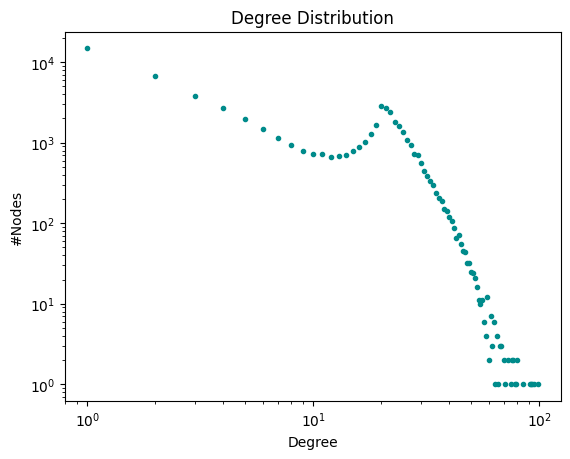

In [ ]:
#plot deg distribution
hist = nx.degree_histogram(G)

plt.plot(range(0, len(hist)), hist, ".", color = "darkcyan")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

Calculating best minimal value for power law fit


<ipython-input-7-0a712c9ec2a4>:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim((min(degree), max(degree)))


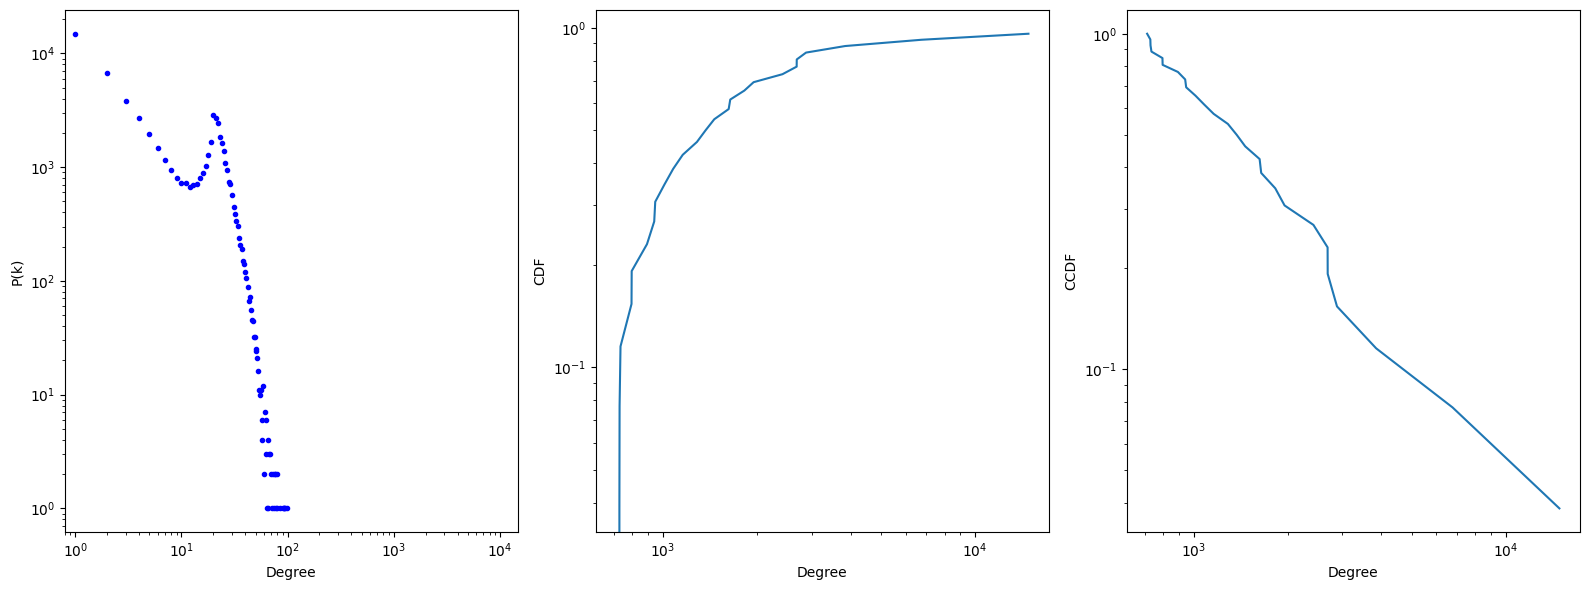

In [ ]:
plot_dist(G)

In [ ]:
x, y = [] , []
for degree_tup in G.degree():
  node_clustering_coefficient = nx.clustering(G,degree_tup[0])
  y.append(node_clustering_coefficient)
  x.append(degree_tup[1])


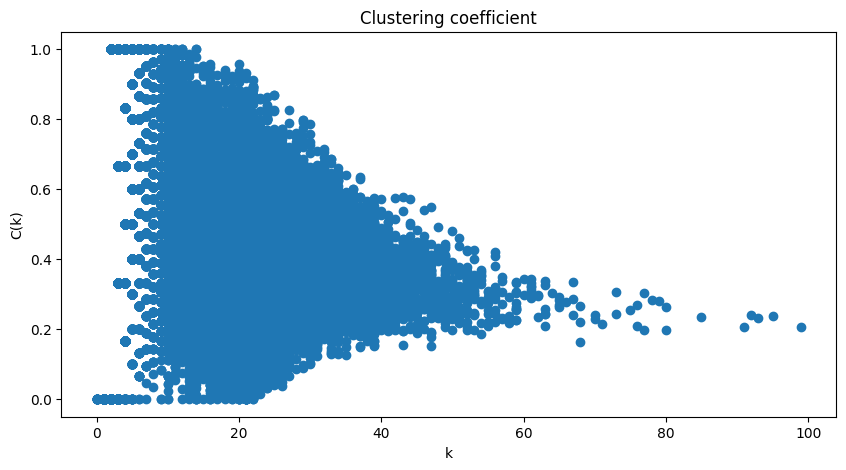

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x, y)

plt.xlabel("k")
plt.ylabel("C(k)")
plt.title("Clustering coefficient")
plt.show()

### Synthetic networks comparison

In [ ]:
(G.number_of_nodes(), math.log(len(G)))

(63717, 11.062206681936356)

In [ ]:
net_char(G)

{'node_num': 63717,
 'edges_num': 373718,
 'directed': False,
 'max_edges_num': 2029896186.0,
 'self_loops_num': 0,
 'average_degree': 11.730558563648634,
 'highest_degree': 99,
 'lowest_degree': 0,
 'num_connected_components': 21,
 'size_biggest_component': 63695,
 'density': 0.0001841069521572075,
 'triangles_number': 3118005,
 'avg_clustering_coefficient': 0.3962871936993666,
 'assortativity': 0.17026428225006165}

In [ ]:
er = nx.fast_gnp_random_graph(len(G), p = 0.000184, seed=42, directed=False)
net_char(er)

{'node_num': 63717,
 'edges_num': 372908,
 'directed': False,
 'max_edges_num': 2029896186.0,
 'self_loops_num': 0,
 'average_degree': 11.705133637804668,
 'highest_degree': 28,
 'lowest_degree': 1,
 'num_connected_components': 1,
 'size_biggest_component': 63717,
 'density': 0.00018370791697226236,
 'triangles_number': 888,
 'avg_clustering_coefficient': 0.00020112583174959755,
 'assortativity': 0.0016374780220473133}

In [ ]:
ba = nx.barabasi_albert_graph(len(G), 6, seed = 42)
net_char(ba)

{'node_num': 63717,
 'edges_num': 382266,
 'directed': False,
 'max_edges_num': 2029896186.0,
 'self_loops_num': 0,
 'average_degree': 11.998870003295824,
 'highest_degree': 983,
 'lowest_degree': 6,
 'num_connected_components': 1,
 'size_biggest_component': 63717,
 'density': 0.00018831800494845601,
 'triangles_number': 19068,
 'avg_clustering_coefficient': 0.0018370216607090603,
 'assortativity': -0.014429992427894086}

In [ ]:
ws = nx.watts_strogatz_graph(len(G), k=12, p=0.2, seed = 42)
net_char(ws)

{'node_num': 63717,
 'edges_num': 382302,
 'directed': False,
 'max_edges_num': 2029896186.0,
 'self_loops_num': 0,
 'average_degree': 12.0,
 'highest_degree': 20,
 'lowest_degree': 7,
 'num_connected_components': 1,
 'size_biggest_component': 63717,
 'density': 0.0001883357398455647,
 'triangles_number': 1469055,
 'avg_clustering_coefficient': 0.35329841418118113,
 'assortativity': -0.013532806843379168}

In [ ]:
cm = nx.configuration_model([x[1] for x in G.degree()],
                            nx.Graph(), seed = 42)
net_char(cm)

{'node_num': 63717,
 'edges_num': 373602,
 'directed': False,
 'max_edges_num': 2029896186.0,
 'self_loops_num': 6,
 'average_degree': 11.726917463157399,
 'highest_degree': 99,
 'lowest_degree': 0,
 'num_connected_components': 168,
 'size_biggest_component': 63399,
 'density': 0.00018404980637763512,
 'triangles_number': 4839,
 'avg_clustering_coefficient': 0.0005107299137820155,
 'assortativity': -3.1908564973665575e-05}

In [ ]:
networks = {'Artists Graph' : G,
            'Erdős-Rényi' : er,
            'Barabási–Albert' : ba,
            'Watts Strogatz' : ws,
            'Configuration Model' : cm
}

### Degree analysis - comparison

In [ ]:
def degree_distribution_plot(gaph_dict):
    fig = plt.figure(figsize=(16,8))
    labels = []
    for name, graph in gaph_dict.items():
      degrees = graph.degree()
      values = sorted(set([value for key, value in degrees]))
      hist = [[value for key, value in degrees].count(x) for x in values]
      labels.append(name)

      plt.loglog(values, hist, 'o-')

      fontsize = 15

    plt.yticks(fontsize=fontsize, alpha=1)
    plt.xlabel("Degree", fontsize=fontsize)
    plt.ylabel("Number of nodes", fontsize=fontsize)
    plt.title("Degree Distribution", fontsize=fontsize)
    plt.legend(labels, fontsize=fontsize)
    plt.grid(axis='both', alpha=.3)
    plt.xlim([0, 2*10**2])

    plt.show()

<ipython-input-31-a7c6f1532826>:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 2*10**2])


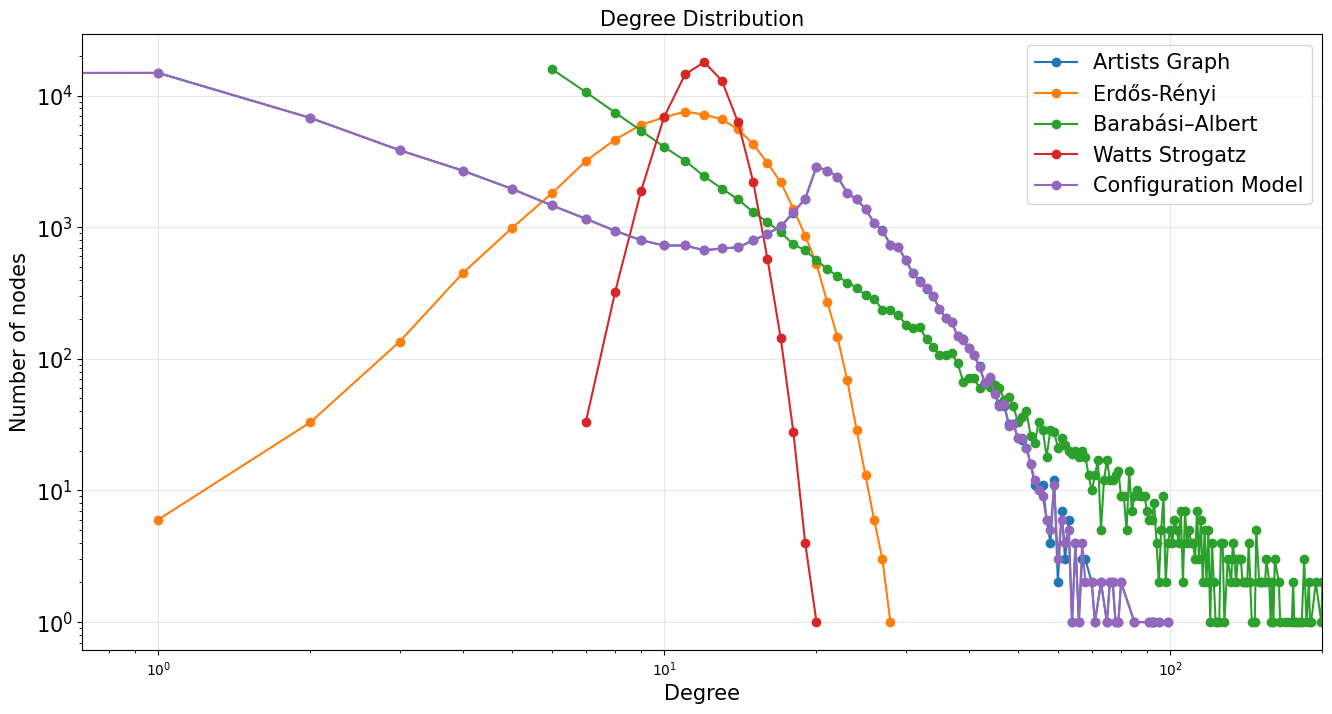

In [ ]:
degree_distribution_plot(networks)

In [ ]:
for net, graph in networks.items():
  hubs, not_hubs = hub_net(graph, 80)
  print('Hubs in ' , net, len(hubs))

Hubs in  Artists Graph 8
Hubs in  Erdős-Rényi 0
Hubs in  Barabási–Albert 418
Hubs in  Watts Strogatz 0
Hubs in  Configuration Model 8


In [ ]:
degree = dict(G.degree())
top20 = sorted(degree.items(), key=lambda item: item[1], reverse = True)[:20]
top20 = [tup + (G.nodes[tup[0]]['artist_first_genre'][0],) for tup in top20]
top20


[('Lucky Ali', 99, 'filmi'),
 ('Lazar Berman', 95, 'classical piano'),
 ('Sunidhi Chauhan', 93, 'filmi'),
 ('Roop Kumar Rathod', 92, 'filmi'),
 ('Alisha Chinai', 91, 'filmi'),
 ('Vishal Dadlani', 85, 'filmi'),
 ('Sviatoslav Richter', 80, 'classical'),
 ('Concerto Italiano', 80, 'baroque ensemble'),
 ('Maria João Pires', 79, 'classical performance'),
 ('András Schiff', 78, 'classical performance'),
 ('Mika Singh', 77, 'filmi'),
 ('Vladimir Horowitz', 77, 'classical'),
 ('Midel', 76, 'argentine hip hop'),
 ('90degrees', 76, 'sped up'),
 ('Anu Malik', 75, 'filmi'),
 ('Trebol Clan', 73, 'latin hip hop'),
 ('Playa Limbo', 73, 'latin arena pop'),
 ('London Baroque', 71, 'baroque ensemble'),
 ('Dario Marianelli', 70, 'orchestral soundtrack'),
 ('Dan Stone', 70, 'progressive house')]

In [ ]:
hubs, not_hubs = hub_net(G, 70)
(hubs, len(hubs))


(['Vishal Dadlani',
  'Sunidhi Chauhan',
  'Dario Marianelli',
  'Trebol Clan',
  'Playa Limbo',
  'Mika Singh',
  'Midel',
  'Lucky Ali',
  'Roop Kumar Rathod',
  'Anu Malik',
  'Alisha Chinai',
  '90degrees',
  'Lazar Berman',
  'Maria João Pires',
  'András Schiff',
  'Vladimir Horowitz',
  'Sviatoslav Richter',
  'London Baroque',
  'Concerto Italiano',
  'Dan Stone'],
 20)

### Ego-graph for node with highest degree

In [ ]:
ego = nx.ego_graph(G, "Lucky Ali")

In [ ]:
len(ego)

100

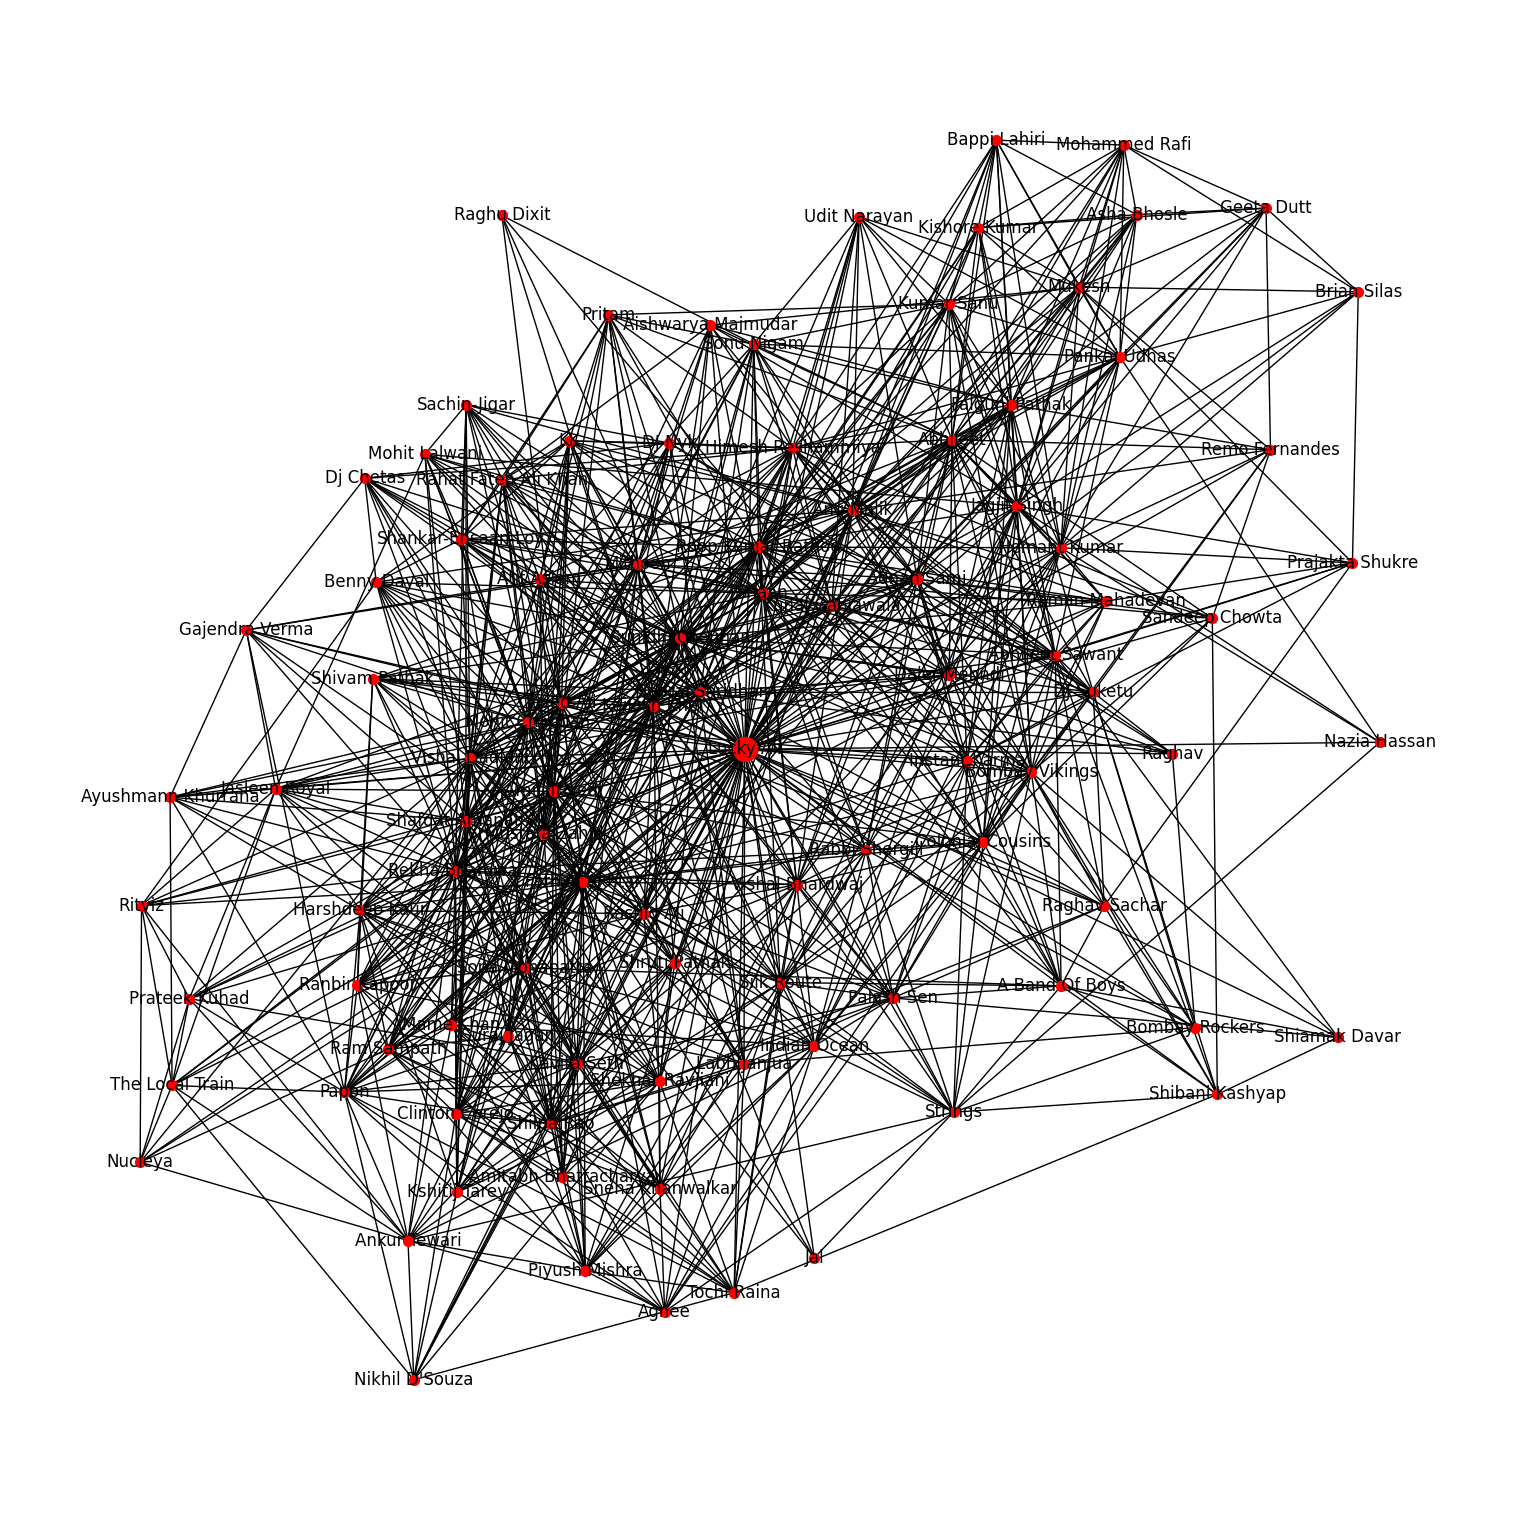

In [ ]:
node_and_degree = G.degree()
node_and_degree
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

hub_ego = nx.ego_graph(G, largest_hub)
plt.figure(figsize=(15,15))

pos = nx.spring_layout(hub_ego, seed=42)  # Seed layout for reproducibility
g_ego = nx.draw(hub_ego, pos, node_color="red", node_size=50, with_labels=True)

options = {"node_size": 300, "node_color": "r", }
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()

nx.write_graphml(g_ego, "ego_net")

### Connected Components

In [ ]:
#we focus only on nets having more then a single giant component
connected_components_G = sorted(list(nx.connected_components(G)), key=len, reverse = True)
connected_components_cm = sorted(list(nx.connected_components(cm)), key=len, reverse = True)

In [ ]:
len_components_G = [len(comp) for comp in connected_components_G ]
set(len_components_G)

{1, 2, 63695}

In [ ]:
len_components_cm = [len(comp) for comp in connected_components_cm ]
set(len_components_cm)

{1, 2, 3, 63399}

In [ ]:
networks_giant_components = {net : graph.subgraph(sorted(list(nx.connected_components(graph)), key=len, reverse = True)[0])
                           for net, graph in networks.items()}


In [ ]:
networks_giant_components.keys()

dict_keys(['Artists Graph', 'Erdős-Rényi', 'Barabási–Albert', 'Watts Strogatz', 'Configuration Model'])

### Approximate Path length analysis

In [ ]:
for net, biggest_component in networks_giant_components.items():
  print(net, ' - ', graph, end = '\n\n')

  print('Approximated average shortest path: ', approximate_shortest_path_length(biggest_component, seed = 42), end = '\n\n')

  print('2-sweep approximated diameter: ', nx.approximation.diameter(biggest_component, seed = 42), end = '\n\n')

Artists Graph  -  Graph with 63717 nodes and 373602 edges

Approximated average shortest path:  (8.7309, 0.1381851707461456)

2-sweep approximated diameter:  23

Erdős-Rényi  -  Graph with 63717 nodes and 373602 edges

Approximated average shortest path:  (4.7633, 0.04818011241501237)

2-sweep approximated diameter:  8

Barabási–Albert  -  Graph with 63717 nodes and 373602 edges

Approximated average shortest path:  (3.95365, 0.041735428110850355)

2-sweep approximated diameter:  6

Watts Strogatz  -  Graph with 63717 nodes and 373602 edges

Approximated average shortest path:  (5.80125, 0.048390118158086096)

2-sweep approximated diameter:  8

Configuration Model  -  Graph with 63717 nodes and 373602 edges

Approximated average shortest path:  (4.57465, 0.05614849989451229)

2-sweep approximated diameter:  12



### Centrality analysis

In [ ]:
def plot_barplot(ranks_degrees, n = 10, method_name = 'Degree'):
    names = [tup[0] for tup in ranks_degrees]
    scores = [tup[1] for tup in ranks_degrees]

    top_names = names[:n]
    top_scores = scores[:n]

    plt.figure(figsize=(14,5))
    x_pos = np.arange(len(top_names))
    plt.bar(x_pos, top_scores)
    plt.xlabel("Artists")
    plt.xticks(x_pos, top_names, rotation = 15, fontsize=10)

    plt.ylabel(method_name + ' Centrality Score', fontsize = 10)
    plt.show()

    return top_names, top_scores

In [ ]:
degrees = dict(G.degree())
ranks_degrees = [(key, value) for key, value in sorted(degrees.items(), key=lambda item: -item[1])]

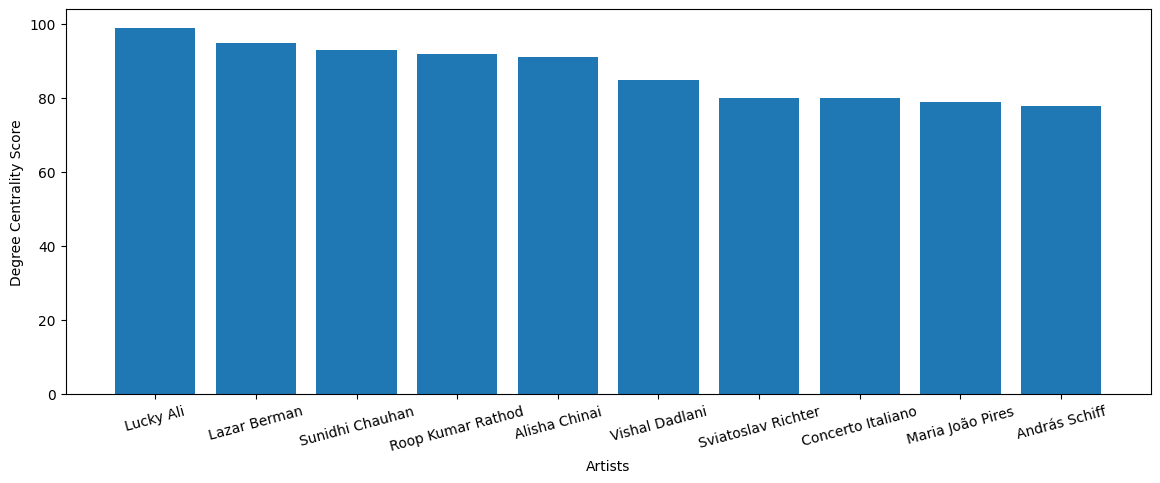

['filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi']

In [ ]:
names, scores = plot_barplot(ranks_degrees, 10 , 'Degree')
[G.nodes[names[0]]['artist_first_genre'][0] for name in names]

In [ ]:
pagerank = nx.pagerank(G)
ranks_pagerank = [(key, value) for key, value in sorted(pagerank.items(), key=lambda item: -item[1])]

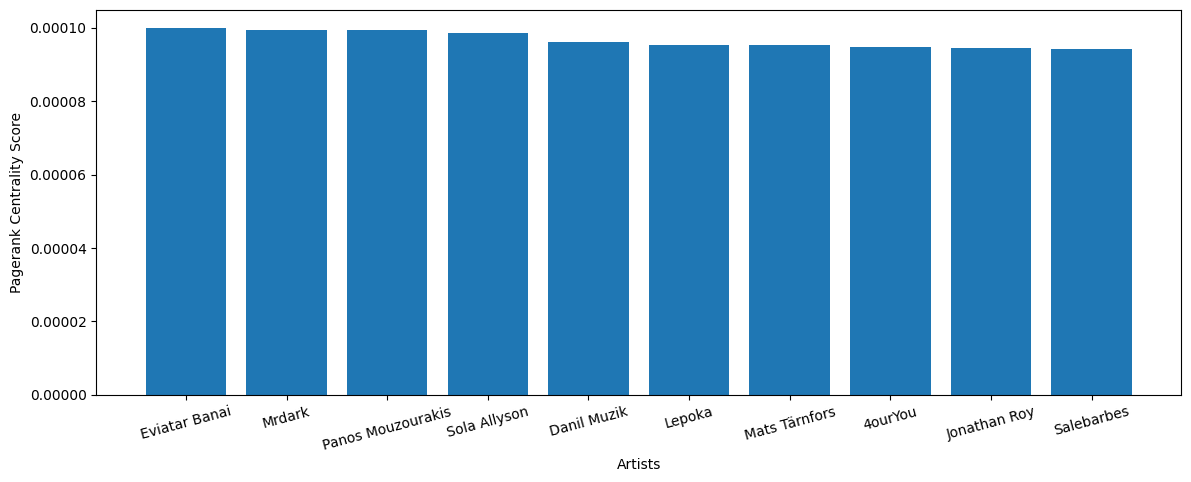

['classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop',
 'classic israeli pop']

In [ ]:
names, scores = plot_barplot(ranks_pagerank, 10, 'Pagerank')
[G.nodes[names[0]]['artist_first_genre'][0] for name in names]

In [ ]:
eigen = nx.eigenvector_centrality(G)
ranks_ev = [(key, value) for key, value in sorted(eigen.items(), key=lambda item: -item[1])]

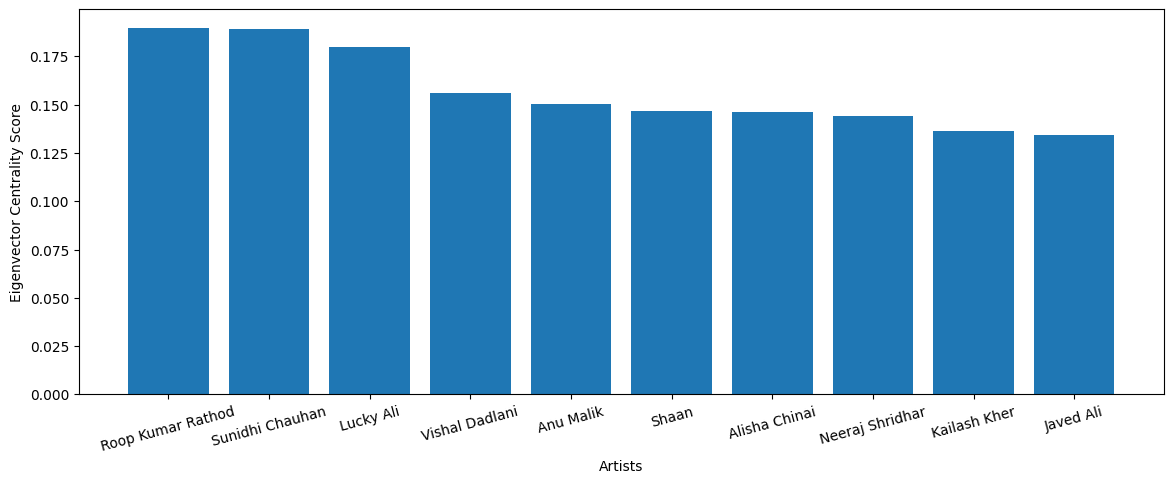

['filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi',
 'filmi']

In [ ]:
names, scores = plot_barplot(ranks_ev, 10, 'Eigenvector')
[G.nodes[names[0]]['artist_first_genre'][0] for name in names]

In [ ]:
harmonic = nx.harmonic_centrality(G)
ranks_harmonic = [(key, value) for key, value in sorted(harmonic.items(), key=lambda item: -item[1])]

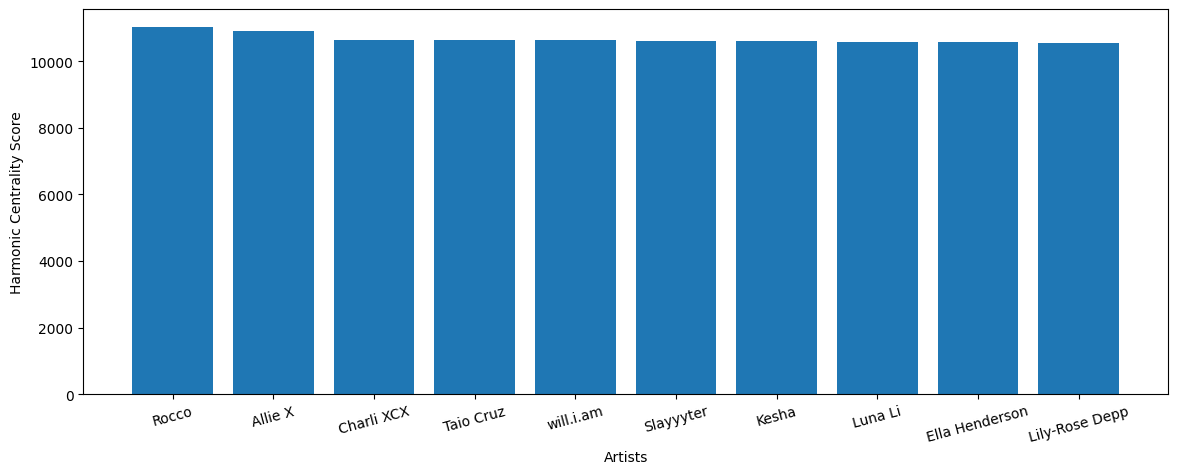

['bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b']

In [ ]:
names, scores = plot_barplot(ranks_harmonic, 10, 'Harmonic')
[G.nodes[names[0]]['artist_first_genre'][0] for name in names]

In [ ]:
closeness = nx.closeness_centrality(G)
ranks_closeness = [(key, value) for key, value in sorted(closeness.items(), key=lambda item: -item[1])]

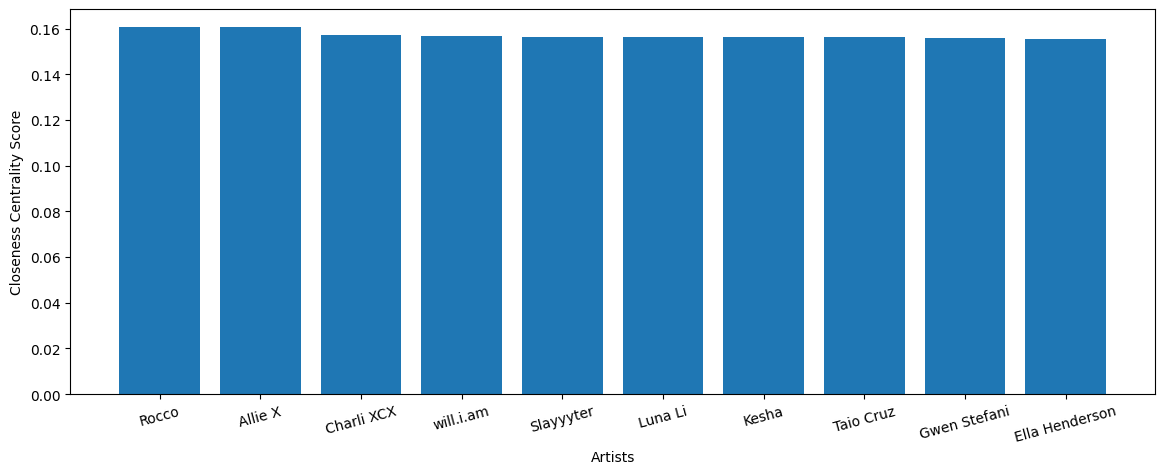

['bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b',
 'bedroom r&b']

In [ ]:
names, scores = plot_barplot(ranks_closeness, 10, 'Closeness')
[G.nodes[names[0]]['artist_first_genre'][0] for name in names]

### Assortativity analysis

In [ ]:
knn = nx.average_degree_connectivity(G)
knn = dict(sorted(knn.items()))

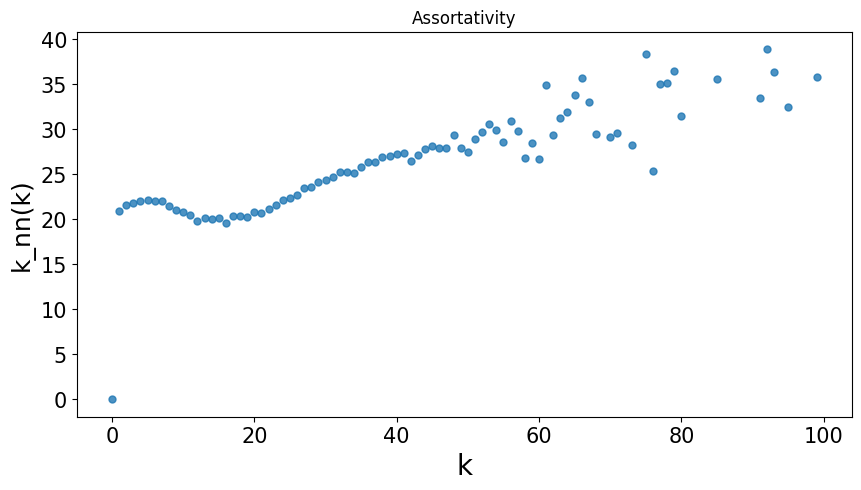

In [ ]:
#What's the expected neighbors' degree of a node given its degree?

plt.figure(figsize=(10,5))

plt.plot(list(knn.keys()), list(knn.values()), '.', ms=10, alpha=0.8)
plt.xlabel("k", fontsize=20)
plt.ylabel("k_nn(k)",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Assortativity")
plt.show()

In [ ]:
n_followers = [[G.nodes[node]['artist_n_followers']] for node in list(G.nodes)]

In [ ]:
nodes_bins = KBinsDiscretizer(n_bins=250, encode = 'ordinal').fit_transform(n_followers)

In [ ]:
for node, bin_label in zip(list(G.nodes), nodes_bins):
  G.nodes[node]['bin_follower'] = int(bin_label)

In [ ]:
print('Assorativity for main genre: ' , nx.attribute_assortativity_coefficient(G, 'main_genre'))
print('Assorativity for pupularity: ' , nx.attribute_assortativity_coefficient(G, 'artist_popularity'))
print('Assorativity for num_followers: ' , nx.attribute_assortativity_coefficient(G, 'bin_follower'))

Assorativity for main genre:  0.33579822306856755
Assorativity for pupularity:  0.01907475083943305
Assorativity for num_followers:  0.011624845413076264
